# How much time buses spend at stops

## Imports

In [1]:
import warnings
from datetime import datetime
from pathlib import Path

import geopandas as gpd
import gtfs_kit as gk
import pandas as pd
from google.transit.gtfs_realtime_pb2 import FeedMessage

## General settings

In [2]:
rid = "3815"
pb2_path = Path("../data")
sched_path = "../data/itm_south_east_gtfs.zip"

## Load pb2 data

In [3]:
trips = []
for f in sorted(pb2_path.glob("*.pb2")):
    msg = FeedMessage()
    msg.ParseFromString(f.read_bytes())
    for t in msg.entity:
        if t.vehicle.trip.route_id == "3815":
            trips.append(t)

In [4]:
# 1 == STOPPED_AT
# 2 == IN_TRANSIT_TO
rows = [
    {
        "id": t.id,
        "trip_id": t.vehicle.trip.trip_id,
        "route_id": t.vehicle.trip.route_id,
        "start_time": t.vehicle.trip.start_time,
        "start_date": t.vehicle.trip.start_date,
        "latitude": t.vehicle.position.latitude,
        "longitude": t.vehicle.position.longitude,
        "current_stop": t.vehicle.current_stop_sequence,
        "current_status": t.vehicle.current_status,
        "timestamp": datetime.utcfromtimestamp(t.vehicle.timestamp),
        "vehicle": t.vehicle.vehicle.id,
    }
    for t in trips
]
df = pd.DataFrame(rows).drop_duplicates()
df.timestamp = df.timestamp.dt.tz_localize("UTC")
df.head(2)

,id,trip_id,route_id,start_time,start_date,latitude,longitude,current_stop,current_status,timestamp,vehicle
0,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,51.753353,-1.26963,0,1,2022-10-15 16:37:37+00:00,SCOX-10439
1,9393660296727820281,VJ4453880e00c6b8699902fa03cd32d0b0e4f5bb82,3815,15:28:00,20221015,51.753132,-1.26951,34,2,2022-10-15 16:37:29+00:00,SCOX-10670


In [5]:
tid = df.iloc[0].trip_id
trip = df.loc[df.trip_id == tid]
trip = (
    trip.assign(geometry=gpd.points_from_xy(x=trip.longitude, y=trip.latitude))
    .drop(["longitude", "latitude"], axis=1)
    .pipe(gpd.GeoDataFrame, crs=4326)
)
trip.head()

,id,trip_id,route_id,start_time,start_date,current_stop,current_status,timestamp,vehicle,geometry
0,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,0,1,2022-10-15 16:37:37+00:00,SCOX-10439,POINT (-1.26963 51.75335)
7,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,0,1,2022-10-15 16:38:17+00:00,SCOX-10439,POINT (-1.26962 51.75343)
31,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,0,1,2022-10-15 16:38:37+00:00,SCOX-10439,POINT (-1.26961 51.75341)
55,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,0,1,2022-10-15 16:38:58+00:00,SCOX-10439,POINT (-1.26962 51.75340)
76,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,1,2,2022-10-15 16:39:38+00:00,SCOX-10439,POINT (-1.26922 51.75351)


<AxesSubplot: >

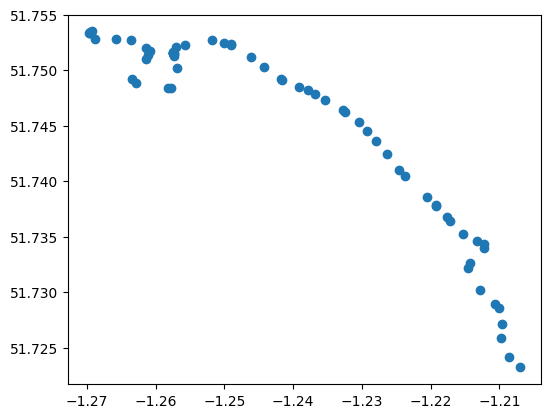

In [6]:
trip.plot()

## Get bus stop location data

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fd = gk.read_feed(sched_path, dist_units="mi")

In [8]:
tid_trips = fd.trips.loc[fd.trips.trip_id == tid]
tid_trips

,route_id,service_id,trip_id,trip_headsign,block_id,shape_id,wheelchair_accessible,trip_direction_name,vehicle_journey_code
63817,3815,1059,VJbf1af309850819f0c13270b1c82a48b16c1448bf,Blackbird Leys,835564a49b8a93a30cbda07c97fea7d826c4a2a5,RPSP10bf6d71d7afd57dfe00872bfd1ba8372ffd628b,0,NaN,VJ651


In [9]:
tid_stop_times = fd.stop_times.loc[fd.stop_times.trip_id == tid]
tid_stop_times.head(6)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_direction_name
2276277,VJbf1af309850819f0c13270b1c82a48b16c1448bf,17:34:00,17:34:00,340000006R2,0,NaN,0,1,0.000000,1,NaN
2276278,VJbf1af309850819f0c13270b1c82a48b16c1448bf,17:36:00,17:36:00,340002070D1,1,NaN,0,0,0.478460,0,NaN
2276279,VJbf1af309850819f0c13270b1c82a48b16c1448bf,17:37:00,17:40:00,340002074M1,2,NaN,0,0,0.857154,1,NaN
2276280,VJbf1af309850819f0c13270b1c82a48b16c1448bf,17:44:00,17:44:00,340001989S2,3,NaN,0,0,1.617230,0,NaN
2276281,VJbf1af309850819f0c13270b1c82a48b16c1448bf,17:47:00,17:47:00,340002074G5,4,NaN,0,0,2.068400,1,NaN
2276282,VJbf1af309850819f0c13270b1c82a48b16c1448bf,17:49:00,17:49:00,340001992K1,5,NaN,0,0,2.551940,0,NaN


In [10]:
stops = fd.stops.loc[fd.stops.stop_id.isin(tid_stop_times.stop_id)]
stops = (
    stops.assign(geometry=gpd.points_from_xy(x=stops.stop_lon, y=stops.stop_lat))
    .drop(["stop_lon", "stop_lat"], axis=1)
    .pipe(gpd.GeoDataFrame, crs=4326)
)
stops.geometry = stops.to_crs(epsg=3857).buffer(30).to_crs(epsg=4326)
stops.head()

,stop_id,stop_code,stop_name,wheelchair_boarding,location_type,parent_station,platform_code,geometry
35761,340001992K1,oxfgjmtm,Queens Lane (Stop K1),0,NaN,NaN,NaN,"POLYGON ((-1.25126 51.75279, -1.25126 51.75277..."
35767,340001989S2,oxfgjmap,Speedwell Street (Stop S2),0,NaN,NaN,NaN,"POLYGON ((-1.25774 51.74848, -1.25774 51.74846..."
35774,340000006R2,oxfamjmj,Railway Station (Stop R2),0,NaN,NaN,NaN,"POLYGON ((-1.26939 51.75333, -1.26939 51.75331..."
35793,340002074G5,oxfgwapd,St Aldates (Stop G5),0,NaN,NaN,NaN,"POLYGON ((-1.25719 51.75151, -1.25719 51.75149..."
35887,340001257BTW,oxfagwpd,The Original Swan,0,NaN,NaN,NaN,"POLYGON ((-1.21207 51.73377, -1.21207 51.73375..."


## And compare them!

In [11]:
def cmap(x):
    return "green" if x else "red"

In [22]:
t = trip[["geometry"]].assign(tp=0)
s = stops[["geometry"]].assign(tp=1)
pd.concat([t, s]).explore(tiles="CartoDB positron", cmap=cmap, color="tp")

In [19]:
trip_stops = trip.sjoin(stops, how="left")[["current_stop", "current_status", "timestamp", "stop_id", "stop_name"]]
trip_stops = trip_stops.assign(cum_stop=trip_stops.groupby("stop_id").cumcount())
trip_stops.head(20)

,current_stop,current_status,timestamp,stop_id,stop_name,cum_stop
0,0,1,2022-10-15 16:37:37+00:00,340000006R2,Railway Station (Stop R2),0.0
7,0,1,2022-10-15 16:38:17+00:00,340000006R2,Railway Station (Stop R2),1.0
31,0,1,2022-10-15 16:38:37+00:00,340000006R2,Railway Station (Stop R2),2.0
55,0,1,2022-10-15 16:38:58+00:00,340000006R2,Railway Station (Stop R2),3.0
76,1,2,2022-10-15 16:39:38+00:00,NaN,NaN,NaN
94,1,2,2022-10-15 16:39:59+00:00,NaN,NaN,NaN
109,1,2,2022-10-15 16:40:39+00:00,NaN,NaN,NaN
127,2,2,2022-10-15 16:41:00+00:00,NaN,NaN,NaN
148,2,2,2022-10-15 16:41:41+00:00,NaN,NaN,NaN
169,2,2,2022-10-15 16:42:01+00:00,NaN,NaN,NaN


In [18]:
long_stops = trip_stops.loc[trip_stops.stop_id.isin(trip_stops.loc[trip_stops.cum_stop >= 1].stop_id.unique())]
long_stops

,current_stop,current_status,timestamp,stop_id,stop_name,cum_stop
0,0,1,2022-10-15 16:37:37+00:00,340000006R2,Railway Station (Stop R2),0.0
7,0,1,2022-10-15 16:38:17+00:00,340000006R2,Railway Station (Stop R2),1.0
31,0,1,2022-10-15 16:38:37+00:00,340000006R2,Railway Station (Stop R2),2.0
55,0,1,2022-10-15 16:38:58+00:00,340000006R2,Railway Station (Stop R2),3.0
367,5,2,2022-10-15 16:46:25+00:00,340002074G5,St Aldates (Stop G5),0.0
388,5,2,2022-10-15 16:47:06+00:00,340002074G5,St Aldates (Stop G5),1.0
409,5,2,2022-10-15 16:47:26+00:00,340002074G5,St Aldates (Stop G5),2.0
430,5,2,2022-10-15 16:48:06+00:00,340002074G5,St Aldates (Stop G5),3.0
451,5,2,2022-10-15 16:48:27+00:00,340002074G5,St Aldates (Stop G5),4.0
472,5,2,2022-10-15 16:49:07+00:00,340002074G5,St Aldates (Stop G5),5.0


In [15]:
def diff_calc(x):
    return x.iloc[-1] - x.iloc[0]

In [16]:
stop_time = trip_stops.groupby(["stop_id", "stop_name"]).agg(diff_calc)
stop_time

,,current_stop,current_status,timestamp,cum_stop
stop_id,stop_name,,,,
340000006R2,Railway Station (Stop R2),0,0,0 days 00:01:21,3.0
340001126TYN,The Plain,0,0,0 days 00:00:21,1.0
340001198OUT,Manzil Way,1,0,0 days 00:00:20,1.0
340001200OPH,Marsh Road,0,0,0 days 00:00:20,1.0
340002074G5,St Aldates (Stop G5),0,0,0 days 00:03:02,6.0
